In [306]:
using DataFrames, CSV
using LinearAlgebra, Random, Printf, StatsBase, CategoricalArrays
using Plots, StatsPlots, GRUtils
using Distributions
using Gurobi, JuMP

In [307]:
# Data
data = Matrix(DataFrame(CSV.File("../data/demand.csv")));

# Constants
N = round(Int, (size(data)[1] - 2) / 2)    # number of trips
K = 3 ;                                    # number of shuttles

In [308]:
# Use this cost later to load costs from BingsMap. For now, we will simply use the euclidian distance as shown below.
driving_times = DataFrame(CSV.File("../data/OR_Full_Times.csv"));
origins_names = driving_times[:,1]
destinations_names = names(driving_times)[2:end];
driving_times = Matrix(driving_times)[:,2:end];

# Let's construct the matrix t[i,j]
t = zeros(2*N+2, 2*N+2)

# Create a dictionary
origin_dict = Dict(zip(origins_names,1:length(origins_names)));
destination_dict = Dict(zip(destinations_names,1:length(destinations_names)));


for i in 1:2*N+2
    for j in 1:2*N+2

        orr = data[i,9]
        des = data[j,9]

        # find the index of orr in origins_names
        # orr_index = findfirst(x -> x == orr, origins_names)
        # des_index = findfirst(x -> x == des, destinations_names)

        orr_index = origin_dict[orr]
        des_index = destination_dict[des]

        t[i,j] = driving_times[orr_index, des_index]
    end 
end 

c = t ; #let's consider in this initial model that the travel cost and the time and equivalent. 

In [309]:
a = 1:10

# min of array for indices in a set
function min_of_array_for_indices(array, indices)
    return minimum(array[indices])
end

min_of_array_for_indices (generic function with 1 method)

In [310]:
data[PUD, 8]

58-element Vector{Any}:
 144.2805448637232
 164.15485660055003
 132.0818544720273
 171.92782004250836
 140.3238551190741
 116.05559196567728
 121.24052975260273
 113.18700244825777
 123.56210118510677
 148.4488145893965
 109.01586435346547
 153.51744507958188
 128.15156037173273
   ⋮
 109.62141716438956
 134.09963269520674
  87.86033430323054
 183.36548867498541
 126.43517355302086
 158.10716084729862
  90.98478948920464
 124.54972656286223
 173.3663653698386
 147.38345188094766
 144.26891946588555
 125.53540255471736

In [311]:
minimum(data[PUD,7] - t[1,PUD])

40.1416547899978

In [312]:
# Constants
P = 2:N+1                       # pick up vertices
V =  1:2*N+2
L = 1000  
PUD = 2:2*N+1

# Tighten the time windows
data[1,7] = minimum(data[PUD,7] - t[1,PUD])
data[2*N+2,7] = minimum(data[PUD,7] - t[1,PUD])

data[1,8] = maximum(data[PUD,8] + d[PUD] + t[PUD,2*N+2])
data[2*N+2,8] = maximum(data[PUD,8] + d[PUD] + t[PUD,2*N+2])

# Splitting the data into sublists
q = data[1:2*N+2, 4];
d = data[1:2*N+2, 5];
e = data[1:2*N+2, 7];
l = data[1:2*N+2, 8];

#### The cost matrix

We need to compute the cost matrix t[i,j]. For the moment, we know the cost matrix t[i,j] where i and j are origin-destination pairs. As a recall, we have selected 19 possible origins and 45 possible destinations. As our model here includes 99 trips, our current formulation gives: t[i,j] could be t[67,97] which of course leads to an error. Therefore, we should find a way to compute the cost matrix t[i,j] for each trip.

In [313]:
# compute all possibles pairs of (i,j)
pairs = [(i,j) for i in 1:2*N+2, j in 1:2*N+2]

# Infeasible arcs 1
imp_pairs_1 = [(1,N+i) for i in P] ;
imp_pairs_2 = [(i,2*N+2) for i in P] ;
imp_pairs_3 = [(N+i,i) for i in P] ;

# time windows infeasibility
imp_pairs_4 = [(i,j) for (i,j) in pairs if e[i] + d[i] + t[i,j] > l[j]];
imp_pairs_5 = [(i,j) for i in P for j in P if t[i,j] + d[j] + t[j,N+i] > L] ;

# merge all infeasible arcs
imp_pairs = vcat(imp_pairs_1, imp_pairs_2, imp_pairs_3, imp_pairs_4, imp_pairs_5) ;

feasible_pairs = setdiff(pairs, imp_pairs);  

### The model

In [314]:
model = Model(Gurobi.Optimizer)

V =  1:2*N+2                    # all vertices
P = 2:N+1                       # pick up vertices
D = N+2:2*N+1                   # drop off vertices
PUD = 2:2*N+1                   # all pick up and drop off vertices together (all vertices except depot)

T = fill(100000, K)                # maximum duration of route k
L = 1000      
Q_max = 50                        # maximum time of a drive
Q = fill(Q_max, K)                # capacity of each car
Penalty = 10                         # Penalty 

# Variables
@variable(model, x[1:2*N+2, 1:2*N+2, 1:K] >= 0, Bin)   # x[i, j, k] = 1 if we go from node i to node j with vehicle k.
@variable(model, w[1:2*N+2, 1:K] >= 0, Int)            # w[i,k] load of vehicle k when arriving upon leaving vertex i
@variable(model, r[1:N] >= 0)                          # r[i,k] travel time of passenger i (Note that passenger i is identified by) the vertex i+1
@variable(model, u[1:2*N+2, 1:K] >= 0)                 # u[i,k] time as which the vertex i is served by vehicle k
@variable(model, a[1:2*N+2, 1:K] >= 0)                 # a[i,k] = max{u[i,k] - l[i], 0} (waiting time in excess for l[i] at vertex i for vehicle k)

#############  Constraints  #############

# only one car can bring passenger {i, i+N} to its final destination.
@constraint(model, [i in P], sum(sum(x[i, j, k] for j in V) for k = 1:K) == 1)

# each vehicle starts at the depot
@constraint(model, [k = 1:K], sum(x[1, j, k] for j in V) == 1)

# each vehicle ends at the depot
@constraint(model, [k = 1:K], sum(x[i, 2*N+2, k] for i in V) == 1)

# each passenger is picked and droped by the same car
@constraint(model, [i in P, k = 1:K], sum(x[i, j, k] for j in V) - sum(x[i+N, j, k] for j in V) == 0)

# vehicle k follows the edges sequentially
@constraint(model, [i in PUD, k = 1:K], sum(x[j, i, k] for j in V) - sum(x[i, j, k] for j in V) == 0)

# PREVIOUS the time served of vertex i
# @constraint(model, [i in V, j in V, k = 1:K], u[j, k] >= (u[i, k] + d[i] + t[i, j]) * x[i, j, k])

# BIG M LINEARIZATION
M = zeros(2*N+2, 2*N+2)
for i in 1:2*N+2
    for j in 1:2*N+2
        M[i,j] = max(0, l[i] + d[i] + t[i,j] - e[j])
    end
end
@constraint(model, [(i, j) in feasible_pairs, k = 1:K], u[j, k] >= u[i, k] + d[i] + t[i, j] - M[i,j]*(1-x[i, j, k]))
# @constraint(model, [i in V, j in V, k = 1:K], u[j, k] >= u[i, k] + d[i] + t[i, j] - M[i,j]*(1-x[i, j, k]))

# updating the load of the vehicle
# @constraint(model, [i in V, j in V, k = 1:K], w[j, k] >= (w[i, k] + q[j]) * x[i, j, k])

# BIG M LINEARIZATION
W = zeros(2*N+2, 2*N+2)
for i in 1:2*N+2
    for j in 1:2*N+2
        W[i,j] = min(Q_max, Q_max + q[i])
    end
end
@constraint(model, [(i,j) in feasible_pairs, k = 1:K], w[j, k] >= w[i, k] + q[j] - W[i,j]*(1-x[i, j, k]))
# @constraint(model, [i in V, j in V, k = 1:K], w[j, k] >= w[i, k] + q[j] - W[i,j]*(1-x[i, j, k]))

# updating the travel time of passenger i
@constraint(model, [i in P, k = 1:K], r[i-1] == u[N+i, k] - (u[i, k] + d[i]))

# respecting the total length of a trip
@constraint(model, [k = 1:K], u[2*N+2,k] - u[1,k] >= 0) # NEW
@constraint(model, [k = 1:K], u[2*N+2,k] - u[1,k] <= T[k])

# respecting travel window of passenger i
@constraint(model, [i in V, k = 1:K], e[i] <= u[i,k])
# @constraint(model, [i in V, k = 1:K], u[i,k] <= l[i])
@constraint(model, [i in V, k = 1:K], a[i,k] >= u[i,k] - l[i])

# respecting travel window of passenger i
@constraint(model, [i in P], t[i,i+N] <= r[i-1])
@constraint(model, [i in P], r[i-1] <= L)

# respecting each car's capacity
@constraint(model, [i in V, k = 1:K], max(0, q[i]) <= w[i, k])
@constraint(model, [i in V, k = 1:K], w[i, k] <= min(Q[k], Q[k] + q[i]))

# Force infeasible arcs to be zero
@constraint(model, [(i,j) in imp_pairs, k = 1:K], x[i,j,k] == 0)

# objective
# @objective(model, Min, sum(sum(sum(c[i, j] * x[i, j, k] for k = 1:K) for i in V) for j in V));
@objective(model, Min, sum(sum(c[i, j] * x[i, j, k] for k = 1:K) for (i,j) in feasible_pairs) + Penalty * sum(sum(a[i,k] for k=1:K) for i in V));

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-17


In [315]:
optimize!(model)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 19251 rows, 11369 columns and 81841 nonzeros
Model fingerprint: 0x61438eb4
Variable types: 389 continuous, 10980 integer (10800 binary)
Coefficient statistics:
  Matrix range     [6e-02, 2e+02]
  Objective range  [1e-01, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+05]
Presolve removed 4561 rows and 3693 columns
Presolve time: 0.10s
Presolved: 14690 rows, 7676 columns, 92665 nonzeros
Variable types: 386 continuous, 7290 integer (7101 binary)

Root relaxation: objective 6.116630e+01, 1224 iterations, 0.07 seconds (0.13 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   61.16630    0  139          -   61.16630      -     -    0s
     0     0   61.67837    0  208          -   61.

In [ ]:
x_values = value.(x)
findall(x_values[:, :, :] .== 1)

41-element Vector{CartesianIndex{3}}:
 CartesianIndex(28, 6, 1)
 CartesianIndex(6, 7, 1)
 CartesianIndex(1, 9, 1)
 CartesianIndex(26, 25, 1)
 CartesianIndex(7, 26, 1)
 CartesianIndex(9, 28, 1)
 CartesianIndex(25, 40, 1)
 CartesianIndex(15, 3, 2)
 CartesianIndex(16, 5, 2)
 CartesianIndex(34, 8, 2)
 CartesianIndex(1, 10, 2)
 CartesianIndex(14, 13, 2)
 CartesianIndex(29, 14, 2)
 ⋮
 CartesianIndex(39, 4, 3)
 CartesianIndex(4, 11, 3)
 CartesianIndex(2, 12, 3)
 CartesianIndex(12, 18, 3)
 CartesianIndex(1, 20, 3)
 CartesianIndex(37, 21, 3)
 CartesianIndex(11, 23, 3)
 CartesianIndex(23, 30, 3)
 CartesianIndex(21, 31, 3)
 CartesianIndex(18, 37, 3)
 CartesianIndex(20, 39, 3)
 CartesianIndex(31, 40, 3)

In [ ]:
feasible_pairs

1019-element Vector{Tuple{Int64, Any}}:
 (1, 1)
 (2, 1)
 (3, 1)
 (4, 1)
 (5, 1)
 (6, 1)
 (7, 1)
 (8, 1)
 (9, 1)
 (10, 1)
 (11, 1)
 (12, 1)
 (13, 1)
 ⋮
 (29, 40)
 (30, 40)
 (31, 40)
 (32, 40)
 (33, 40)
 (34, 40)
 (35, 40)
 (36, 40)
 (37, 40)
 (38, 40)
 (39, 40)
 (40, 40)

In [ ]:
u_values = value.(u)

40×3 Matrix{Float64}:
  60.2499   29.1695   88.8462
 139.215   139.215   138.163
  91.4125   95.7995   91.4125
 120.46    107.66    110.881
 145.957   145.957   145.957
 113.371   113.371   113.371
 116.904   127.462   127.462
 131.683   128.226   132.229
  76.5166   82.8812   83.2165
  34.2028   34.2028   34.2028
 123.081   112.081   112.081
 141.36    141.36    139.851
  93.4971   84.9233   84.9233
   ⋮                 
  35.2195   35.2195   35.2195
 137.52    126.52    126.52
 165.063   165.063   163.554
 109.523   100.949   100.949
  86.461    86.461    86.461
 109.216   111.739   115.339
 152.164   161.458   152.164
 175.408   175.408   175.408
 157.038   172.738   157.038
 131.466   131.466   131.466
 113.513   106.563   106.563
 165.345   183.996   171.063

In [ ]:
r_values = value.(r)

19-element Vector{Float64}:
 19.85809903952176
  4.15
  4.666700000000002
  0.0
 35.70010000000016
  4.4667
 23.497205358390545
  2.2333
  0.5167000000000002
 13.939611118694614
 23.20296453792767
 15.52616532125468
 32.650000000000034
 18.927695314632842
 15.50106078462278
 14.5
  6.716700000000003
 29.250100000000174
 14.5

In [ ]:
w_values = round.(Int, value.(w))

40×3 Matrix{Int64}:
 0   0   0
 1   1   1
 1   3   1
 1   1   1
 1  50   1
 1   1   1
 2  50  50
 3  50   3
 1   1   1
 1   1   1
 1   1   2
 1   2   2
 1   2   1
 ⋮      
 0   0   0
 0   0   0
 0   0   0
 0   1   0
 0   1   0
 0  47   3
 0  49   0
 0  49   0
 0   1   2
 0  48   1
 0   0   0
 0  49   0

In [ ]:
function plot_route(df, x_val, w_val, plot_size)
    
    # df: dataframe containing all the input data:
    #     column 1: Passenger ID
    #     column 2: PickUp/DropOff Pos_x
    #     column 3: PickUp/DropOff Pos_y
    #     column 4: load (number of passengers to embark)
    #     column 5: service duration (embark time)
    #     column 6: preferred pick up time
    #     column 7: lower bound of pick up time
    #     column 8: upper bound of pick up time

    # car_nbr: the vehicle number to plot

    # x_val: the values of x
    
    #constants 
    N = round(Int,(size(df)[1]-2)/2)

    cars_used = findall([sum(x_val[:,:,i]) for i=1:size(x_val)[3]] .> 2)
    
    println("Number of cars used: $(length(cars_used))")
    println("The car(s) used are(is): ", cars_used)

    plots = []

    for ii in 1:length(cars_used)

        car = cars_used[ii]

        p = Plots.plot(titlefont=font(20, "Computer Modern"), 
            title="Result for different shutle number: $car",  
            legend = :outertopright,
            format=:png)
        
        customers_deserved = findall(x_val[:, :, car] .== 1)
        pickup_deserved = [elem[1] for elem in customers_deserved] 
        pickup_deserved = [elem for elem in pickup_deserved if elem <= N+1]  

        dropoff_deserved = [elem[1] for elem in customers_deserved] 
        dropoff_deserved = [elem for elem in dropoff_deserved if elem > N+1] 

        # plot the depot
        Plots.scatter!(p, [df[1, 2]], [df[2*N+2, 3]], 
            color="black", 
            markersize=5, 
            labels="Depot", 
            size = (plot_size[1], plot_size[2]),
            )

        # plot all nodes
        for i in pickup_deserved
            pass_ID = round(Integer, df[i,1])

            Plots.scatter!(p, [df[i, 2]], [df[i, 3]],
                color="lightgreen", 
                xlabel="x", ylabel="y",
                labels="PickUp ID: $pass_ID - $(df[i,4]) passenger(s)",  
                annotations = (df[i, 2], df[i, 3], Plots.text("  Pick:$pass_ID", :left, pointsize=10)),
                format=:png,
                markersize=5)
        end

        # plot all nodes
        for i in dropoff_deserved
            pass_ID = round(Integer, df[i,1])

            Plots.scatter!(p, [df[i, 2]], [df[i, 3]],
                color="red", 
                xlabel="x", ylabel="y",
                labels="DropOff ID: $pass_ID - $(df[i,4]) passenger(s)",  
                annotations = (df[i, 2], df[i, 3], Plots.text("  Drop:$pass_ID", :left, pointsize=10)),
                format=:png,
                markersize=5)
        end




        colors = ["black", "red", "green", "blue", "pink"]
        vals = findall(x_val[:, :, car] .== 1)
        for elem in vals
            i, j = elem[1], elem[2]
            Plots.plot!(p, [df[i, 2], df[j, 2]], [df[i, 3], df[j, 3]], color=colors[car], labels="", textposition="bottom left", linewidth=1, arrow=true, arrowwidth=3, format=:png)
        end

        # plot the depot
        Plots.scatter!(p, [df[1, 2]], [df[2*N+2, 3]], 
            titlefont=font(20, "Computer Modern"), 
            color="black", 
            markersize=5, 
            labels="Depot", 
            format=:png)

        vals = findall(x_val[:, :, car] .== 1)
        # extract first element of cartesian index
        vals = [elem[1]-1 for elem in vals]        
        # get the values lower than N+1
        vals = [elem for elem in vals if elem < N+1]  
        # order the list vals
        vals = sort(vals)
        println("The shuttle $car served customers: ", vals)
        push!(plots, p)
    end
    return plots
end



plot_route (generic function with 1 method)

In [ ]:
x_values = round.(Int, value.(x))
w_values = round.(Int, value.(w))
plots = plot_route(data, x_values, w_values, [1100, 650]) ;

Number of cars used: 3
The car(s) used are(is): [1, 2, 3]
The shuttle 1 served customers: [0, 5, 6, 8]
The shuttle 2 served customers: [0, 2, 4, 7, 9, 12, 13, 14, 15, 16, 18]
The shuttle 3 served customers: [0, 1, 3, 10, 11, 17, 19]


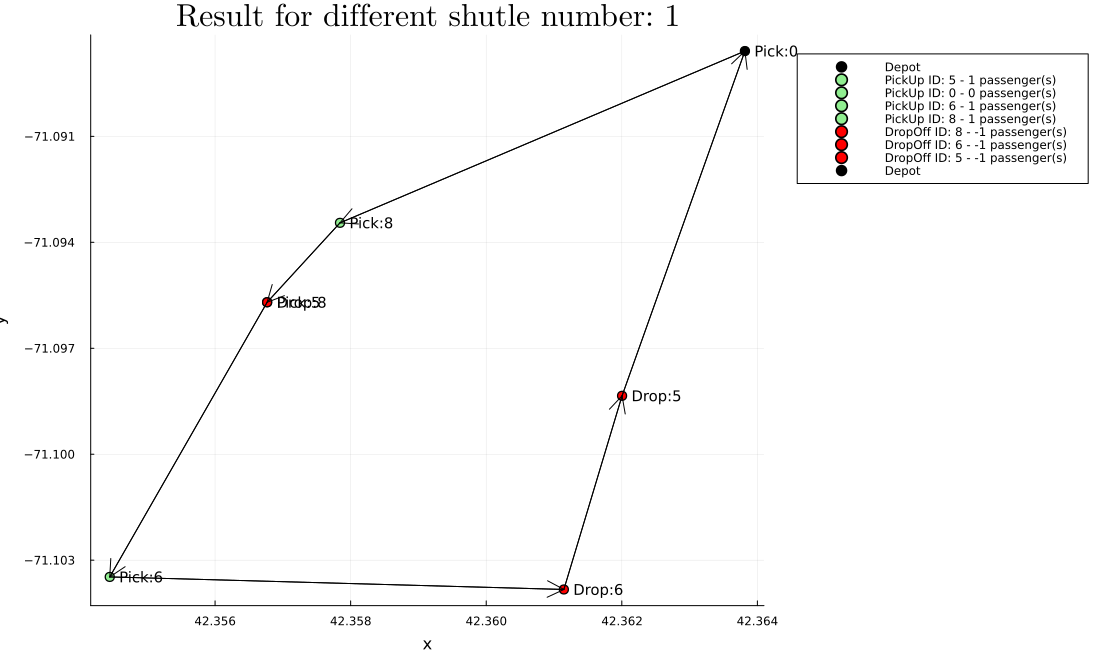

In [ ]:
plots[1]

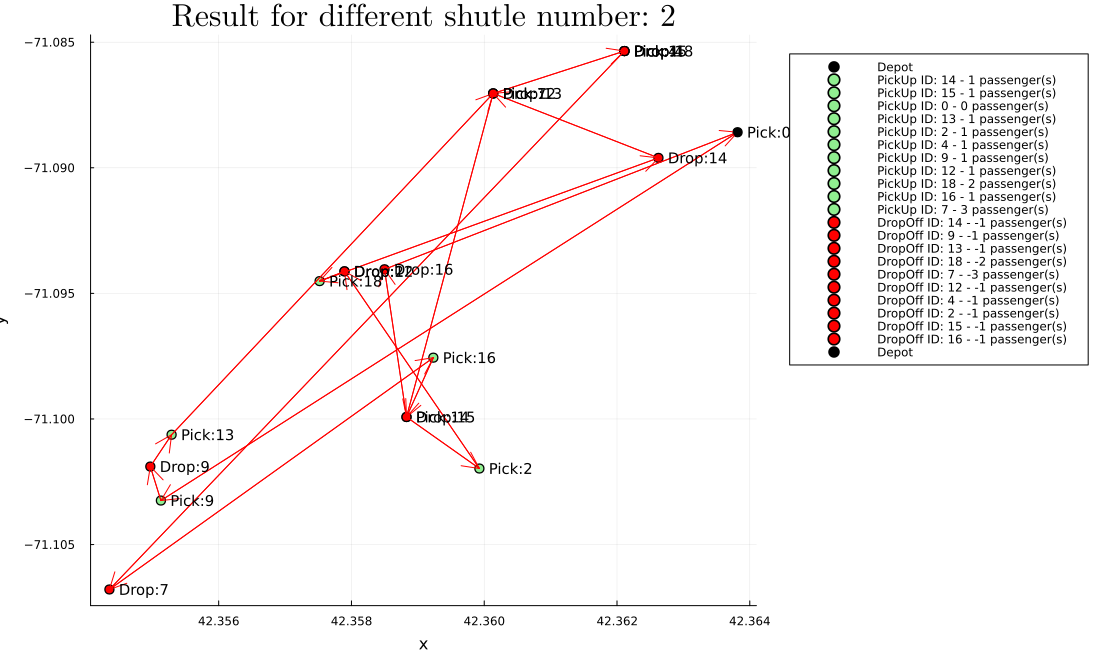

In [ ]:
plots[2]

In [ ]:
plots[3]

LoadError: BoundsError: attempt to access 2-element Vector{Any} at index [3]

In [ ]:
# get the indices all the elements equal to 1 in x_values
vals = [findall(x_values[:, :, i] .== 1)[1] for i=1:K]
vals

3-element Vector{CartesianIndex{2}}:
 CartesianIndex(1, 1)
 CartesianIndex(1, 1)
 CartesianIndex(1, 1)